# 100_Dynamic_Time_Warping

In this notebook I will begin the Time Series Classification process..
* Using an implementation of dynamic time warping (Approach 1) 
* Then apply multiple dimensional reducion techniques

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#100_Dynamic_Time_Warping" data-toc-modified-id="100_Dynamic_Time_Warping-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>100_Dynamic_Time_Warping</a></span></li><li><span><a href="#Notebook-Set-Up" data-toc-modified-id="Notebook-Set-Up-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Notebook Set Up</a></span><ul class="toc-item"><li><span><a href="#Import-Packages" data-toc-modified-id="Import-Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Import Packages</a></span></li><li><span><a href="#Set-Parameters-For-Graphs" data-toc-modified-id="Set-Parameters-For-Graphs-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Set Parameters For Graphs</a></span></li><li><span><a href="#Load-The-Data" data-toc-modified-id="Load-The-Data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Load The Data</a></span></li></ul></li><li><span><a href="#Begin-Time-Series-Classification" data-toc-modified-id="Begin-Time-Series-Classification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Begin Time Series Classification</a></span><ul class="toc-item"><li><span><a href="#Approach-1:-Dynamic-Time-Warping" data-toc-modified-id="Approach-1:-Dynamic-Time-Warping-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Approach 1: Dynamic Time Warping</a></span><ul class="toc-item"><li><span><a href="#Save-The-Results" data-toc-modified-id="Save-The-Results-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Save The Results</a></span></li><li><span><a href="#Store-Metrics-In-Matrix-(2D-Array)" data-toc-modified-id="Store-Metrics-In-Matrix-(2D-Array)-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Store Metrics In Matrix (2D Array)</a></span></li><li><span><a href="#Examine-The-Metrics" data-toc-modified-id="Examine-The-Metrics-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Examine The Metrics</a></span></li></ul></li><li><span><a href="#Apply-Dimension-Reduction-Techniques" data-toc-modified-id="Apply-Dimension-Reduction-Techniques-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Apply Dimension Reduction Techniques</a></span><ul class="toc-item"><li><span><a href="#Multidimensional-scaling-(MDS)" data-toc-modified-id="Multidimensional-scaling-(MDS)-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Multidimensional scaling (MDS)</a></span></li><li><span><a href="#Principal-Coordinates-Analysis--(PCA)" data-toc-modified-id="Principal-Coordinates-Analysis--(PCA)-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Principal Coordinates Analysis  (PCA)</a></span></li><li><span><a href="#T-distributed-Stochastic-Neighbor-Embedding-(tSNE)" data-toc-modified-id="T-distributed-Stochastic-Neighbor-Embedding-(tSNE)-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>T-distributed Stochastic Neighbor Embedding (tSNE)</a></span></li></ul></li></ul></li></ul></div>

# Notebook Set Up

## Import Packages

In [2]:
import pickle
import os.path
import numpy as np
import pandas as pd
from dtw import dtw
from math import sqrt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import (manifold,decomposition)
%matplotlib inline

## Set Parameters For Graphs

In [3]:
plt.rcParams['text.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.markersize'] = 15
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.fontsize'] = 12

## Load The Data

In [4]:
with open('../data/core/core_df.pkl', 'rb') as f:
    df = pickle.load(f)

In [5]:
len(df)

131230

In [6]:
df['hashedathleteid'].nunique()

3311

# Begin Time Series Classification

Create an array of athlete ids which I can later iterate through, for various different purposes 

In [7]:
runners = df['hashedathleteid'].unique()

Create a way to generate the training programmes of the athletes in the form of a series. Where the values in the series represent the distance travelled by the athlete on that given day

In [8]:
training_days = pd.date_range(start='2015-01-11', periods=105, freq='1D')
print(training_days[0])
print(training_days[-1])

2015-01-11 00:00:00
2015-04-25 00:00:00


In [9]:
def get_training(runner_idx):
    s = df[df['hashedathleteid']==runners[runner_idx]][['date','totaldistance']].set_index('date').T.squeeze()
    s_training = s.resample('1D').mean()
    return s_training.reindex(training_days.union(s_training.index)).fillna(0)

## Approach 1: Dynamic Time Warping

Implement a dynamic time warping function, which can take two series as an input and return a similarity metric.

In [11]:
l2_norm = lambda x, y: (x - y) ** 2

def DTWDistance_dict(x,y,s1,s2):
    d, cost_matrix, acc_cost_matrix, path = dtw(s1, s2, dist=l2_norm)
    return (x,y,d)

Use the 'get_training' function above which takes the users id as an input generates that athlete's training programmes as series. Pass every combinational pair of athletes to the dtw funtion, in order to calculate all of the required similarity metrics. Due to the large amounts of metrics that need to be calculated, use parrallel programming to speed up the process

In [ ]:
%%time
from joblib import Parallel, delayed

def gen_args(N):    
    for i in range(N): ## The nested for loop prevents the same metric from being calculated twice
        for j in range(i+1, N):
            s1, s2 = get_training(i), get_training(j)
            yield(i, j, s1, s2)

results = Parallel(n_jobs=60)(delayed(DTWDistance_dict)(i,j,s1,s2) for (i,j,s1,s2) in gen_args(len(runners)))

Ensure that I have all the results

In [ ]:
len(results)

### Save The Results

Due to the large quantity of results, It is best that I save them as a pickle for speed efficiency.

In [ ]:
import pickle
with open('../data/core/dynamic_time_warping_days.pkl', 'wb') as f:
    pickle.dump(results, f)

Reload the results. Or if you are starting the notebook again, you can begin from here.

In [13]:
import pickle
with open('../data/core/dynamic_time_warping_days.pkl', 'rb') as f:
    dtw_results = pickle.load(f)

### Store Metrics In Matrix (2D Array)

So far I have obtained the lower triangle of the athlete similarity matrix. I must change it into a symmetric matrix in order to apply the dimension reduction techniques.

In [14]:
dtw_results[:5]

[(0, 1, 13.926101299142864),
 (0, 2, 20.98238500214286),
 (0, 3, 18.06306356633333),
 (0, 4, 17.26030208247619),
 (0, 5, 15.269123140190471)]

In [15]:
dtw_results[-5:]

[(3307, 3309, 1.3995111255714285),
 (3307, 3310, 0.788278028952381),
 (3308, 3309, 1.1544290839523812),
 (3308, 3310, 0.8347884253809521),
 (3309, 3310, 1.6402698966190472)]

Find the upper triangle (which is the transpose of the lower traingle).

In [16]:
dtw_resultsT = []
for element in dtw_results:
    xVal,yVal,DTW_dist = element
    dtw_resultsT.append((yVal,xVal,DTW_dist))

Find the diagional values. These will be all 0 as an athletes similarity to themselves is zero.

In [17]:
diagonal_values = []
x = 0
while x < len(runners):
    diagonal_values.append((x,x,0)) 
    x+=1

Store these values in an array, and sort into order using their coordinates.

In [ ]:
distances_ordered = dtw_results + dtw_resultsT + diagonal_values
distances_ordered = sorted(distances_ordered)

Construct a 2D array big enough to store all of the metrics

In [20]:
distance_matrix = [[0 for i in range(len(runners))] for j in range(len(runners))]

Store the metrics in the matix. ensure the are in the correct order, but only place the metrics themselves in array (no co-ordinates).

In [21]:
for element in distances_ordered:
    xVal,yVal,DTW_dist = element
    distance_matrix[xVal][yVal]=DTW_dist

In [22]:
distance_matrix = np.asarray(distance_matrix)

### Examine The Metrics

Make sure that all athletes are in the matrix, and that it is symmetric

In [25]:
np.shape(distance_matrix)

(3311, 3311)

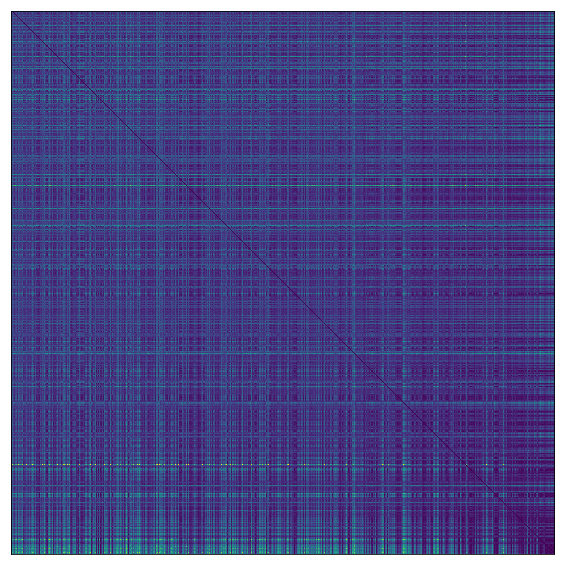

In [379]:
min_max_scaler = preprocessing.MinMaxScaler()
distance_matrix_scaled = min_max_scaler.fit_transform(distance_matrix)
plt.figure(figsize=(10,10))
plt.imshow(distance_matrix_scaled)
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [35]:
pd_dm =  pd.DataFrame(distance_matrix.flatten())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d87bfac50>]],
      dtype=object)

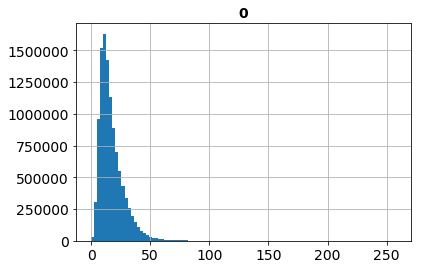

In [36]:
pd_dm.hist(bins=100)

Find the most dissimilar athletes according to the metric, and check if it is credible 

In [37]:
distance_matrix.max()

257.3481884212851

In [48]:
np.transpose(np.where(distance_matrix  > 255))

array([[ 480, 3306],
       [3306,  480]])

In [323]:
xlabels = ['']*len(get_training(0).index)
xlabels[::7] = [item.strftime('%Y-%m-%d') for item in get_training(0).index[::7]]

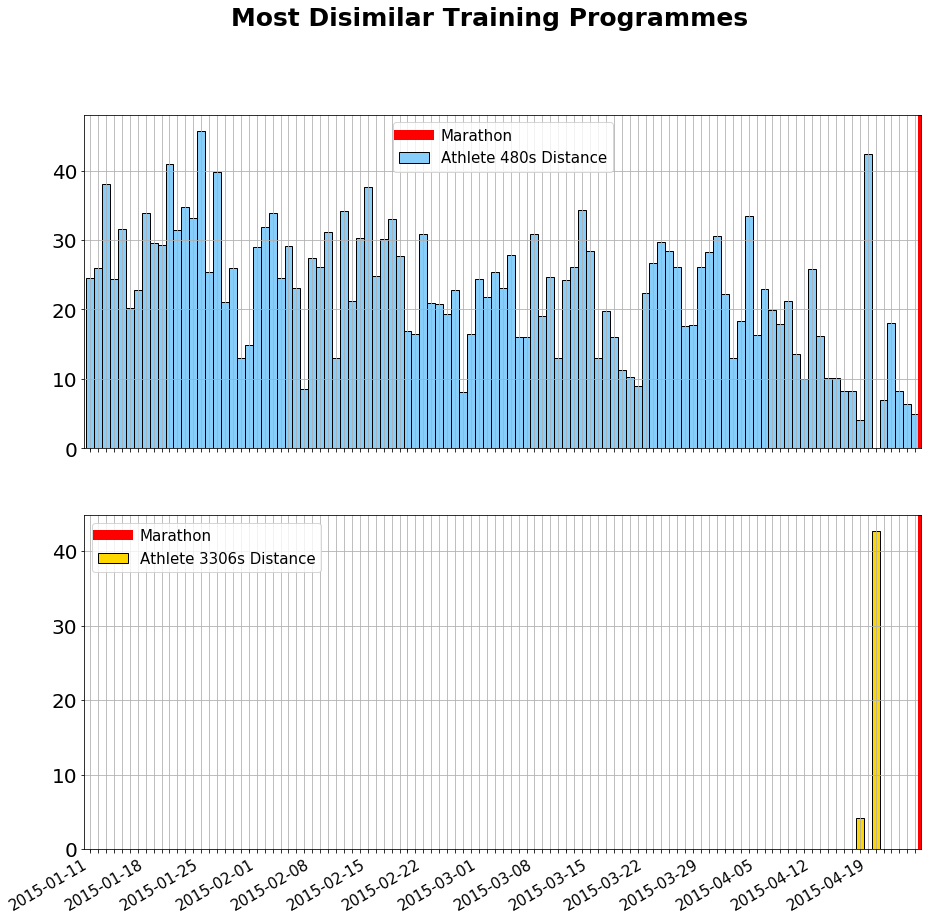

In [378]:
fig, axes = plt.subplots(2, 1, sharex=True,figsize=(15,15))
get_training(480).plot.bar(color='lightskyblue',width=1,edgecolor='black',label='Athlete 480s Distance', ax=axes[0])
get_training(3306).plot.bar(color='gold',width=1,edgecolor='black',label='Athlete 3306s Distance', ax=axes[1])
axes[0].axvline(x=105,linewidth=10, color='r',label='Marathon')
axes[1].axvline(x=105,linewidth=10, color='r',label='Marathon')
fig.subplots_adjust(wspace=0.05)
plt.suptitle('Most Disimilar Training Programmes',size=25,color='k',fontweight="bold")
axes[0].legend(prop={'size': 15})
axes[1].legend(prop={'size': 15})
axes[0].tick_params(axis='y', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[0].xaxis.set_major_formatter(ticker.FixedFormatter(xlabels))
fig.autofmt_xdate()
plt.show()

This looks plausible. Notice the day that athlete 3306 completes its longest run, it is also athlete 480's only day in which they didn't record a session

Now lets check the credibility of the two most similar athletes according to the metric

In [257]:
np.transpose(np.where((distance_matrix  < 0.0002) & (distance_matrix  > 0) ))

array([[2893, 3068],
       [3068, 2893]])

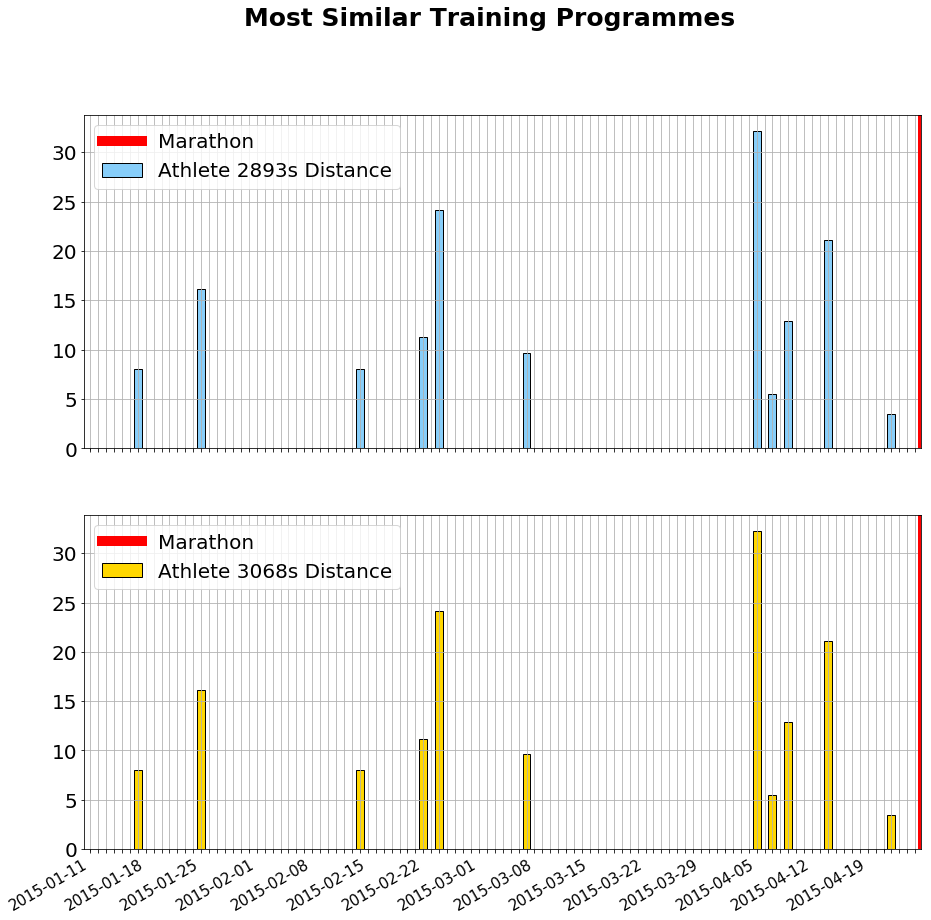

In [377]:
fig, axes = plt.subplots(2, 1, sharex=True,figsize=(15,15))
get_training(2893).plot.bar(color='lightskyblue',width=1,edgecolor='black',label='Athlete 2893s Distance', ax=axes[0])
get_training(3068).plot.bar(color='gold',width=1,edgecolor='black',label='Athlete 3068s Distance', ax=axes[1])
axes[0].axvline(x=105,linewidth=10, color='r',label='Marathon')
axes[1].axvline(x=105,linewidth=10, color='r',label='Marathon')
fig.subplots_adjust(wspace=0.05)
plt.suptitle('Most Similar Training Programmes',size=25,color='k',fontweight="bold")
axes[0].legend(prop={'size': 20})
axes[1].legend(prop={'size': 20})
axes[0].tick_params(axis='y', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[0].xaxis.set_major_formatter(ticker.FixedFormatter(xlabels))
fig.autofmt_xdate()
plt.show()

In [129]:
get_training(3068).where(get_training(3068) > 0).dropna().to_frame()

,totaldistance
2015-01-17,8.0320
2015-01-25,16.0911
2015-02-14,8.0536
2015-02-22,11.1201
2015-02-24,24.1591
2015-03-07,9.6646
2015-04-05,32.2470
2015-04-07,5.4795
2015-04-09,12.9067
2015-04-14,21.1450


In [130]:
get_training(2893).where(get_training(2893) > 0).dropna().to_frame()

,totaldistance
2015-01-17,8.0553
2015-01-25,16.1043
2015-02-14,8.0494
2015-02-22,11.2688
2015-02-24,24.1517
2015-03-07,9.6642
2015-04-05,32.2016
2015-04-07,5.4901
2015-04-09,12.8788
2015-04-14,21.1232


We can see that there almost identical. They may perhaps be running partners, or the same athlete recording their sessions on two seperate devices

## Apply Dimension Reduction Techniques

### Multidimensional scaling (MDS)

In [341]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
                   dissimilarity="precomputed", n_jobs=1, random_state=10)

In [ ]:
pos = mds.fit(distance_matrix).embedding_

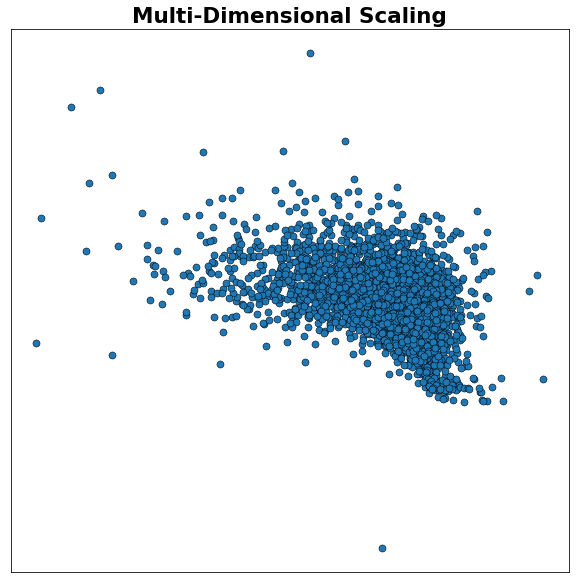

In [355]:
plt.figure(figsize=(10,10))
plt.scatter(pos[:, 0], pos[:, 1], lw=0.5,s=50,edgecolors='k')
plt.title('Multi-Dimensional Scaling',size=21.5)
plt.xticks([], [])
plt.yticks([], [])
plt.show()

### Principal Coordinates Analysis  (PCA)

In [88]:
pca = PCA(n_components=2)
pca_res = pca.fit_transform(distance_matrix)

In [89]:
pca.explained_variance_ratio_

array([0.61042258, 0.3109001 ])

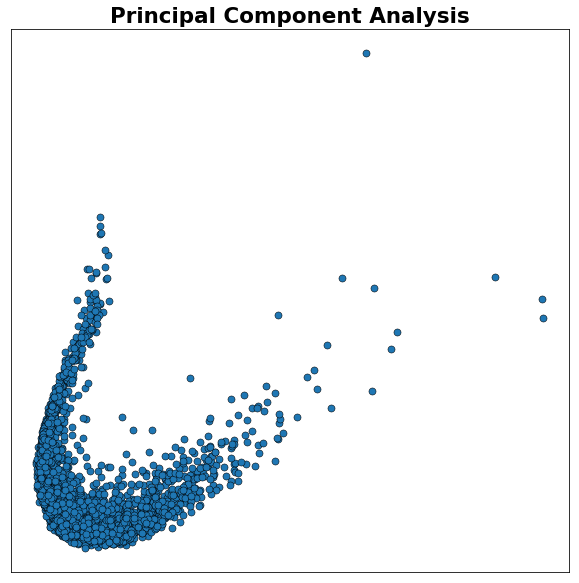

In [354]:
plt.figure(figsize=(10,10))
plt.scatter(pca_res[:, 0], pca_res[:, 1], lw=0.5,s=50,edgecolors='k')
plt.title('Principal Component Analysis',size=21.5)
plt.xticks([], [])
plt.yticks([], [])
plt.show()

### T-distributed Stochastic Neighbor Embedding (tSNE)

In [91]:
tsne = manifold.TSNE(n_components=2, init='random',
                         random_state=0, perplexity=50, learning_rate=500)
tsne_res = tsne.fit_transform(distance_matrix)

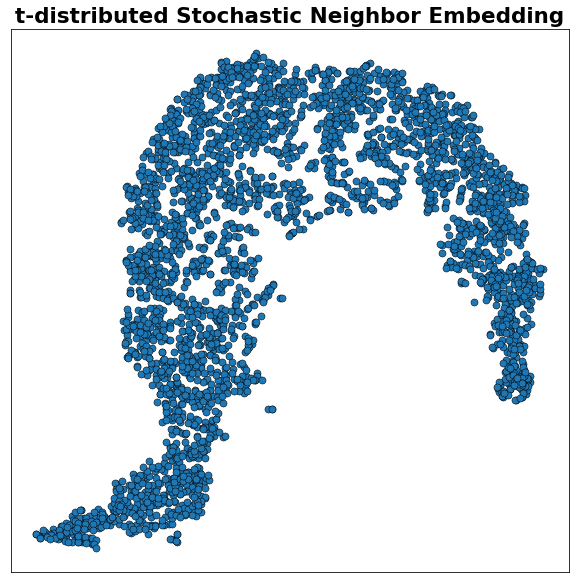

In [353]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_res[:, 0], tsne_res[:, 1], lw=0.5,s=50,edgecolors='k')
plt.title('t-distributed Stochastic Neighbor Embedding',size=21.5)
plt.xticks([], [])
plt.yticks([], [])
plt.show()